The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Programação da taxa de aprendizagem
:label:`sec_scheduler`

Até agora, focamos principalmente na otimização de *algoritmos* para como atualizar os vetores de peso, em vez de na *taxa* na qual eles estão sendo atualizados. No entanto, ajustar a taxa de aprendizagem é frequentemente tão importante quanto o algoritmo real. Existem vários aspectos a considerar:

* Obviamente, a *magnitude* da taxa de aprendizagem é importante. Se for muito grande, a otimização diverge; se for muito pequena, leva muito tempo para treinar ou terminamos com um resultado abaixo do ideal. Vimos anteriormente que o número da condição do problema é importante (consulte, por exemplo, :numref:`sec_momentum` para obter detalhes). Intuitivamente, é a proporção da quantidade de mudança na direção menos sensível em relação à mais sensível.
* Em segundo lugar, a taxa de degradação é tão importante. Se a taxa de aprendizado permanecer alta, podemos simplesmente acabar saltando em torno do mínimo e, portanto, não atingir a otimização.  :numref:`sec_minibatch_sgd` discutiu isso com alguns detalhes e analisamos as garantias de desempenho em :numref:`sec_sgd`. Resumindo, queremos que a taxa diminua, mas provavelmente mais lentamente do que $\mathcal{O}(t^{-\frac{1}{2}})$, o que seria uma boa escolha para problemas convexos.
* Outro aspecto igualmente importante é a *inicialização*. Isso se refere a como os parâmetros são definidos inicialmente (revise :numref:`sec_numerical_stability` para detalhes) e também como eles evoluem inicialmente. Isso tem o nome de *aquecimento*, ou seja, a rapidez com que começamos a nos mover em direção à solução inicialmente. Etapas grandes no início podem não ser benéficas, em particular porque o conjunto inicial de parâmetros é aleatório. As instruções iniciais de atualização também podem ser bastante insignificantes.
* Por último, há uma série de variantes de otimização que realizam ajustes de taxa de aprendizagem cíclica. Isso está além do escopo do capítulo atual. Recomendamos que o leitor analise os detalhes em :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`, por exemplo, como obter melhores soluções calculando a média de um caminho inteiro de parâmetros.

Dado o fato de que são necessários muitos detalhes para gerenciar as taxas de aprendizado, a maioria dos frameworks de aprendizado profundo tem ferramentas para lidar com isso automaticamente. No capítulo atual, revisaremos os efeitos que diferentes programações têm na precisão e também mostraremos como isso pode ser gerenciado de forma eficiente por meio de um *programador de taxa de aprendizagem*.

## Problema Amostra

Começamos com um problema de brinquedo que é barato o suficiente para ser computado facilmente, mas suficientemente não trivial para ilustrar alguns dos principais aspectos. Para isso, escolhemos uma versão ligeiramente modernizada do LeNet (`relu` em vez de ativação `sigmoid`, MaxPooling em vez de AveragePooling), aplicado ao Fashion-MNIST. Além disso, hibridamos a rede para desempenho. Como a maior parte do código é padrão, apenas apresentamos o básico sem uma discussão mais detalhada. Veja :numref:`chap_cnn` para uma atualização conforme necessário.


In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    class Reshape(nn.Module):
        def forward(self, x):
            return x.view(-1,1,28,28)

    model = torch.nn.Sequential(
        Reshape(),
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

Vamos dar uma olhada no que acontece se invocarmos esse algoritmo com configurações padrão, como uma taxa de aprendizado de $0,3$ e treinar por $30$ iterações. Observe como a precisão do treinamento continua aumentando enquanto o progresso em termos de precisão do teste para além de um ponto. A lacuna entre as duas curvas indica sobreajuste.


train loss 0.168, train acc 0.935, test acc 0.894


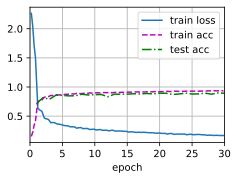

In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## Agendadores

Uma forma de ajustar a taxa de aprendizagem é defini-la explicitamente em cada etapa. Isso é convenientemente alcançado pelo método `set_learning_rate`. Poderíamos ajustá-lo para baixo após cada época (ou mesmo após cada minibatch), por exemplo, de uma maneira dinâmica em resposta a como a otimização está progredindo.


In [3]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


De maneira mais geral, queremos definir um planejador. Quando chamado com o número de atualizações, ele retorna o valor apropriado da taxa de aprendizado. Vamos definir um simples que define a taxa de aprendizagem para $\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$.


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

Vamos representar graficamente seu comportamento em uma faixa de valores.


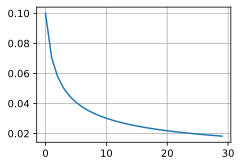

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Agora vamos ver como isso funciona para o treinamento no Fashion-MNIST. Simplesmente fornecemos o escalonador como um argumento adicional para o algoritmo de treinamento.


train loss 0.273, train acc 0.901, test acc 0.876


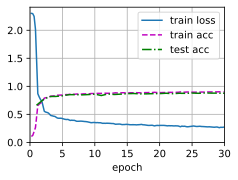

In [6]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

Isso funcionou um pouco melhor do que antes. Duas coisas se destacam: a curva era um pouco mais suave do que antes. Em segundo lugar, houve menos ajuste excessivo. Infelizmente, não é uma questão bem resolvida por que certas estratégias levam a menos ajustes excessivos em *teoria*. Há algum argumento de que um tamanho de passo menor levará a parâmetros mais próximos de zero e, portanto, mais simples. No entanto, isso não explica o fenômeno inteiramente, uma vez que não paramos realmente cedo, mas simplesmente reduzimos a taxa de aprendizagem suavemente.

## Políticas

Embora não possamos cobrir toda a variedade de programadores de taxa de aprendizagem, tentamos fornecer uma breve visão geral das políticas populares abaixo. As escolhas comuns são decaimento polinomial e esquemas constantes por partes. Além disso, verificou-se que as programações de taxa de aprendizado de cosseno funcionam bem empiricamente em alguns problemas. Por último, em alguns problemas, é benéfico aquecer o otimizador antes de usar altas taxas de aprendizado.

### Planejador de Fator

Uma alternativa para um decaimento polinomial seria um multiplicativo, que é $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ para $\alpha \in (0, 1)$. Para evitar que a taxa de aprendizagem diminua além de um limite inferior razoável, a equação de atualização é frequentemente modificada para $\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$.


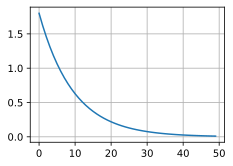

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

Isso também pode ser realizado por um agendador embutido no MXNet por meio do objeto `lr_scheduler.FactorScheduler`. Leva mais alguns parâmetros, como período de aquecimento, modo de aquecimento (linear ou constante), o número máximo de atualizações desejadas, etc .; No futuro, usaremos os agendadores integrados conforme apropriado e apenas explicaremos sua funcionalidade aqui. Conforme ilustrado, é bastante simples construir seu próprio agendador, se necessário.

### Planejador de Fatores Multiplos

Uma estratégia comum para treinar redes profundas é manter a taxa de aprendizado constante e diminuí-la em uma determinada quantidade de vez em quando. Ou seja, dado um conjunto de vezes quando diminuir a taxa, como $s = \{5, 10, 20\}$ diminuir $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ sempre que $t \in s$. Supondo que os valores sejam reduzidos à metade em cada etapa, podemos implementar isso da seguinte maneira.


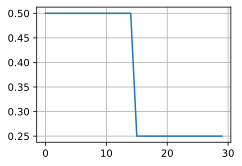

In [8]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

A intuição por trás dessa programação de taxa de aprendizado constante por partes é que se permite que a otimização prossiga até que um ponto estacionário seja alcançado em termos de distribuição de vetores de peso. Então (e somente então) diminuímos a taxa de forma a obter um proxy de maior qualidade para um bom mínimo local. O exemplo abaixo mostra como isso pode produzir soluções cada vez melhores.


train loss 0.194, train acc 0.926, test acc 0.901


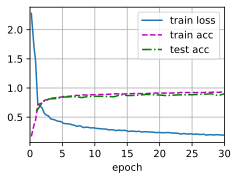

In [9]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### Programador de Cosseno

Uma heurística bastante desconcertante foi proposta por :cite:`Loshchilov.Hutter.2016`. Baseia-se na observação de que podemos não querer diminuir a taxa de aprendizado muito drasticamente no início e, além disso, podemos querer "refinar" a solução no final usando uma taxa de aprendizado muito pequena. Isso resulta em um esquema semelhante ao cosseno com a seguinte forma funcional para taxas de aprendizado no intervalo $t \in [0, T]$.

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

Aqui $\eta_0$ é a taxa de aprendizado inicial, $\eta_T$ é a taxa alvo no momento $T$. Além disso, para $t > T$ simplesmente fixamos o valor em $\eta_T$ sem aumentá-lo novamente. No exemplo a seguir, definimos a etapa de atualização máxima $T = 20$.


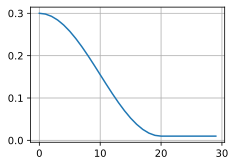

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

No contexto da visão computacional, este cronograma *pode* levar a melhores resultados. Observe, entretanto, que tais melhorias não são garantidas (como pode ser visto abaixo).


train loss 0.215, train acc 0.920, test acc 0.895


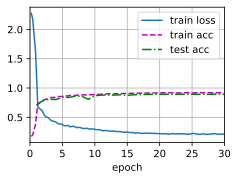

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### Aquecimento


Em alguns casos, inicializar os parâmetros não é suficiente para garantir uma boa solução. Isso é particularmente um problema para alguns projetos de rede avançados que podem levar a problemas de otimização instáveis. Poderíamos resolver isso escolhendo uma taxa de aprendizado suficientemente pequena para evitar divergências no início. Infelizmente, isso significa que o progresso é lento. Por outro lado, uma grande taxa de aprendizado inicialmente leva à divergência.

Uma solução bastante simples para esse dilema é usar um período de aquecimento durante o qual a taxa de aprendizado *aumenta* até seu máximo inicial e esfriar a taxa até o final do processo de otimização. Para simplificar, normalmente usa-se um aumento linear para esse propósito. Isso leva a uma programação do formulário indicado abaixo.


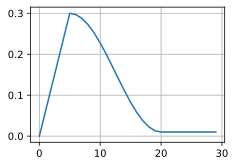

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Observe que a rede converge melhor inicialmente (em particular observe o desempenho durante as primeiras 5 épocas).


train loss 0.197, train acc 0.928, test acc 0.900


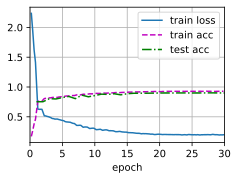

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

O aquecimento pode ser aplicado a qualquer agendador (não apenas cosseno). Para uma discussão mais detalhada sobre cronogramas de taxas de aprendizagem e muitos outros experimentos, consulte também :cite:`Gotmare.Keskar.Xiong.ea.2018`. Em particular, eles descobrem que uma fase de aquecimento limita a quantidade de divergência de parâmetros em redes muito profundas. Isso faz sentido intuitivamente, pois esperaríamos divergências significativas devido à inicialização aleatória nas partes da rede que levam mais tempo para progredir no início.

## Sumário

* Diminuir a taxa de aprendizado durante o treinamento pode levar a uma maior precisão e (o que é mais desconcertante) à redução do ajuste excessivo do modelo.
* Uma diminuição por partes da taxa de aprendizagem sempre que o progresso atinge um platô é eficaz na prática. Essencialmente, isso garante que convergiremos de forma eficiente para uma solução adequada e só então reduziremos a variação inerente dos parâmetros, reduzindo a taxa de aprendizagem.
* Os planejadores de cosseno são populares para alguns problemas de visão computacional. Veja, por exemplo, [GluonCV](http://gluon-cv.mxnet.io) para detalhes de tal planejador.
* Um período de aquecimento antes da otimização pode evitar divergências.
* A otimização serve a vários propósitos no aprendizado profundo. Além de minimizar o objetivo do treinamento, diferentes escolhas de algoritmos de otimização e programação da taxa de aprendizagem podem levar a quantidades bastante diferentes de generalização e overfitting no conjunto de teste (para a mesma quantidade de erro de treinamento).

## Exercícios

1. Experimente o comportamento de otimização para uma determinada taxa de aprendizagem fixa. Qual é o melhor modelo que você pode obter dessa forma?
1. Como a convergência muda se você alterar o expoente da diminuição na taxa de aprendizado? Use `PolyScheduler` para sua conveniência nos experimentos.
1. Aplique o programador de cosseno a grandes problemas de visão computacional, por exemplo, treinamento ImageNet. Como isso afeta o desempenho em relação a outros agendadores?
1. Quanto tempo deve durar o aquecimento?
1. Você pode conectar otimização e amostragem? Comece usando os resultados de :cite:`Welling.Teh.2011` em Stochastic Gradient Langevin Dynamics.


[Discussão](https://discuss.d2l.ai/t/1080)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTc3Nzg0NTU1OCwxMjUzMTczNDM4XX0=
-->
